# ZeroShot utilizando Hugging Face

### Escrito por Eduardo Juliana e João Paulo em outubro 2025

In [1]:
# pacotes a serem instalados

!pip install pymongo[srv,tls]
!pip install dnspython
!pip install python-docx
!pip install sentence-transformers nltk
!pip install transformers torch
!pip install langdetect



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=576e919d0e70f89b798b27513f729e3b6e7a2cecc759d65d090584170d3c69ff
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [2]:
# =========================
# Pacotes a serem usados
# =========================

# Utilidades e sistema
import os
import re
import json
import time
from pprint import pprint
from collections import Counter
from typing import List, Dict, Any

# Requisições e web scraping
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from urllib.parse import urlparse

# Processamento de texto e NLP
import nltk
from nltk.tokenize import sent_tokenize
from langdetect import detect, DetectorFactory
from sentence_transformers import SentenceTransformer

# Manipulação e análise de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning e métricas
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# Transformers / LLM
import torch
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForCausalLM
)


# =========================
# Downloads e configurações
# =========================

# Download do tokenizer/punkt do NLTK
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Configuração do modelo

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando GPU" if device == "cuda" else "Usando CPU")

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None
)

Usando GPU


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Lista fixa com todas as classificações possíveis

In [3]:
todas_as_classificacoes = [
    "verdadeiro",
    "falso",
    "falta contexto",
    "exagerado",
    "subestimado",
    "contraditório",
    "insustentável"
]

classificacoes_sinonimos = {
    "verdadeiro": [
        "verdadeiro", "correto", "confirmado", "factual", "exato", "comprovado", "real"
    ],
    "falso": [
        "falso", "incorreto", "inverídico", "mentira", "inventado", "enganoso", "errado"
    ],
    "falta contexto": [
        "falta contexto", "parcial", "incompleto", "sem detalhes", "necessita contexto", "ambíguo"
    ],
    "exagerado": [
        "exagerado", "superdimensionado", "inflado", "amplificado", "excessivo"
    ],
    "subestimado": [
        "subestimado", "minimizado", "menosprezado", "reduzido", "subvalorizado"
    ],
    "contraditório": [
        "contraditório", "incoerente", "em conflito", "divergente", "discrepante"
    ],
    "insustentável": [
        "insustentável", "sem base", "sem evidência", "não comprovado", "infundado", "não verificável"
    ]
}

LIMITE = 408

## Contagem dos tipos de classificação
Mostra as classificações oficiais e as desconhecidas

In [ ]:
# Carregar o JSON
with open('noticias_lupa.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Limitar a X notícias
data = data[:LIMITE]

# Contar total de notícias
total_noticias = len(data)
print(f"Total de notícias no arquivo: {total_noticias}\n")

# Contar ocorrências reais
classificacoes = [item['classificacao'].lower() for item in data if 'classificacao' in item]
contagem = Counter(classificacoes)

# Garantir que todas apareçam, mesmo com 0
contagem_completa = {classe: contagem.get(classe, 0) for classe in todas_as_classificacoes}

# Identificar classificações que estão fora da lista oficial
classificacoes_extras = {classe: count for classe, count in contagem.items() if classe not in todas_as_classificacoes}

# Ordenar por quantidade (do maior para o menor)
contagem_ordenada = sorted(contagem_completa.items(), key=lambda x: x[1], reverse=True)

# Exibir resultados oficiais
print("Classificações oficiais:")
for classificacao, count in contagem_ordenada:
    print(f"{classificacao}: {count}")

# Exibir classificações desconhecidas
print("\nClassificações fora da lista oficial:")
if classificacoes_extras:
    for classificacao, count in classificacoes_extras.items():
      # se classificacao é " "
        if classificacao == "":
            classificacao = "em branco"

        print(f"{classificacao}: {count}")
else:
  print("Nenhuma classificação desconhecida encontrada.")

Total de notícias no arquivo: 408

Classificações oficiais:
falso: 368
falta contexto: 29
exagerado: 2
insustentável: 1
verdadeiro: 0
subestimado: 0
contraditório: 0

Classificações fora da lista oficial:
em branco: 7
páscoa: 1


## Filtragem de notícias
Cria o json com somente as noticias dentro das classificações oficiais

In [ ]:
todos_sinonimos = [s for lista in classificacoes_sinonimos.values() for s in lista]
dados = []
ARQUIVO_SAIDA = "noticiasFIL_lupa.json"

for item in data:
    titulo = item['titulo']
    classificacao = item['classificacao']
    descricao = item['descricao']

    padrao = r"\b(" + "|".join(map(re.escape, todos_sinonimos)) + r")\b"

    # Remove palavras de classificação/sinônimos + quebras de linha + múltiplos espaços
    descricao_limpa = re.sub(padrao, "", descricao, flags=re.IGNORECASE)
    #titulo_limpo = re.sub(padrao, "", titulo, flags=re.IGNORECASE)

    # Substitui quebras de linha por espaço e remove espaços extras
    descricao_limpa = " ".join(descricao_limpa.replace("\n", " ").split())
    #titulo_limpo = " ".join(titulo_limpo.replace("\n", " ").split())

    if classificacao.lower() in [c.lower() for c in todas_as_classificacoes]:
        dados.append({
        "titulo": titulo,
        "descricao": descricao_limpa,
        "classificacao": classificacao.lower()
        })


#salva em arquivo filtrado
with open(ARQUIVO_SAIDA, "w", encoding="utf-8") as f:
    json.dump(dados, f, ensure_ascii=False, indent=2)
    print(f"Arquivo salvo: {ARQUIVO_SAIDA}")


print(f"Total de notícias: {len(dados)}")


Arquivo salvo: noticiasFIL_lupa.json
Total de notícias: 400


## Gráfico de frequencia de classificações (Ground Truth)
Classificações da LUPA

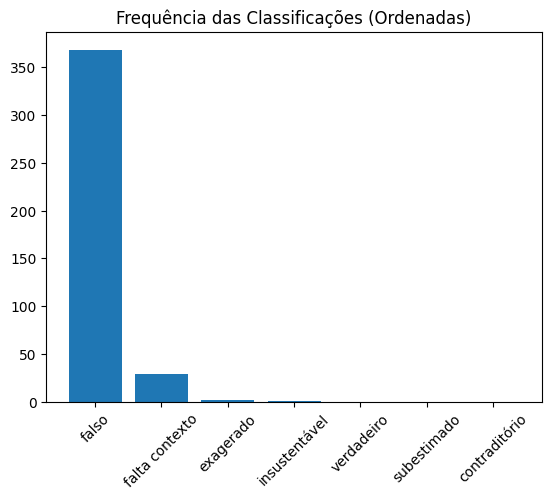

In [ ]:
# Dados separados para o gráfico
labels = [c[0] for c in contagem_ordenada]
values = [c[1] for c in contagem_ordenada]

plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Frequência das Classificações (Ordenadas)")
plt.show()

## Gerador de prompt (não funcionou)

In [ ]:
# # ==========================
# # Caminhos e parâmetros
# # ==========================
# ARQUIVO_JSON = "noticiasFIL_lupa.json"      # arquivo de entrada com título e descrição
# ARQUIVO_SAIDA = "contextoPModelo.json"      # arquivo de saída com o texto verificado


# # ==========================
# # Função auxiliar de limpeza
# # ==========================
# def limpar_texto(texto: str) -> str:
#     """
#     Remove espaços duplicados, quebras de linha excessivas e caracteres estranhos.
#     """
#     texto = re.sub(r'\s+', ' ', texto)        # substitui múltiplos espaços por 1
#     texto = re.sub(r'^\W+|\W+$', '', texto)   # remove caracteres não alfanuméricos no início/fim
#     return texto.strip()

# # ==========================
# # Função de limpeza automática
# # ==========================
# def extrair_contexto(resposta: str) -> str:
#     """
#     Extrai e limpa o texto de contexto (resumo) da resposta do modelo.
#     Se o modelo não usar marcadores como 'Resumo:' ou 'Contexto:', retorna todo o texto.
#     """
#     # Remove repetições do prompt, caso o modelo repita
#     resposta = resposta.split("resumo:", 1)[-1].strip()

#     # Tenta capturar parte antes de "Palavras-chave"
#     match_contexto = re.search(
#         r"(?i)(?:contexto|resumo)[:\-–> ]*\s*(.*?)(?=Palavras[- ]?chave[:\-–> ]*|$)",
#         resposta,
#     )

#     if match_contexto:
#         contexto_limpo = limpar_texto(match_contexto.group(1))
#     else:
#         # Se não houver marcador, usa todo o texto como contexto
#         contexto_limpo = limpar_texto(resposta)

#     return contexto_limpo

# # ==========================
# # Execução principal
# # ==========================
# with open(ARQUIVO_JSON, "r", encoding="utf-8") as f:
#     noticias = json.load(f)

# noticias = noticias[:LIMITE]
# resultados = []

# for item in noticias:
#     titulo = item.get("titulo", "")
#     descricao = item.get("descricao", "")
#     classificacao_oficial = item.get("classificacao", "")

#     # ==========================
#     # Contexto e instruções
#     # ==========================
#     contexto = f"""
#         Título: {titulo}
#         Descrição: {descricao}
#         Resuma os textos acima em uma frase ou parágrafo curto, sem emitir julgamentos ou conclusões.
#         Comece diretamente.
#     """

#     # Monta o prompt unindo contexto, instruções e dados da notícia
#     prompt = f"""{contexto}
#       resumo:"""

#     # Tokeniza e gera texto
#     inputs = tokenizer(prompt, return_tensors="pt").to(device)
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=150,
#         temperature=0.3,
#         do_sample=False,
#         pad_token_id=tokenizer.eos_token_id
#     )

#     # Decodifica e limpa
#     resposta = tokenizer.decode(outputs[0], skip_special_tokens=True)

#     # Remove repetições do prompt
#     resposta = re.sub(r"Você receberá.*reexcreva.*", "", resposta, flags=re.IGNORECASE)

#     # Remove blocos de código ou strings triplas
#     resposta = re.sub(r'("""|\'\'\').*', '', resposta, flags=re.DOTALL)

#     # Remove linhas que começam com "# In[" ou "def "
#     resposta = re.sub(r'^(# In\[.*|def .*|class .*)', '', resposta, flags=re.MULTILINE)

#     # Strip final
#     resposta = resposta.strip()

#     # Extrai o contexto
#     contexto_limpo = extrair_contexto(resposta)

#     # Armazena o resultado
#     resultados.append({
#         "titulo": titulo,
#         "descricao": descricao,
#         "classificacao_oficial": classificacao_oficial,
#         "resumo": contexto_limpo
#     })

# print("\n=== RESPOSTA ===\n", resposta)

# # ==========================
# # Salva o arquivo final
# # ==========================
# with open(ARQUIVO_SAIDA, "w", encoding="utf-8") as f:
#     json.dump(resultados, f, ensure_ascii=False, indent=2)

# print(f"Arquivo salvo: {ARQUIVO_SAIDA}")


## Novo Limite
Para quando precisamos alterar de acordo com as noticias que sobraram


In [ ]:
LIMITE = 400

## Seleção de palavras-chave das notícias

In [ ]:
# ==========================
# Caminhos e parâmetros
# ==========================
ARQUIVO_JSON = "noticiasFIL_lupa.json"      # arquivo de entrada com título e descrição
ARQUIVO_SAIDA = "palavrasChavePModelo.json"      # arquivo de saída com o texto verificado

# ==========================
# Execução principal
# ==========================
with open(ARQUIVO_JSON, "r", encoding="utf-8") as f:
    noticias = json.load(f)

noticias = noticias[:LIMITE]
resultados = []

for item in noticias:
    titulo = item.get("titulo", "")
    descricao = item.get("descricao", "")
    classificacao_oficial = item.get("classificacao", "")

    # ==========================
    # Contexto e instruções
    # ==========================
    contexto = f"""
        Você receberá um título e uma descrição de uma notícia.
        Pegue 8 palavras-chave desses textos e escreva.
        Título: {titulo}
        Descrição: {descricao}
    """

    # Monta o prompt unindo contexto, instruções e dados da notícia
    prompt = f"""{contexto}
      palavrasChave:"""

    # Tokeniza e gera texto
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        temperature=0.3,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decodifica e limpa
    resposta = tokenizer.decode(outputs[0], skip_special_tokens=True)

    match_palavras = re.search(r"(?i)Palavras[- ]?chave:\s*(.*)", resposta)

    palavrasChave = []
    if match_palavras:
        texto_palavras = match_palavras.group(1)

        # Remove colchetes, aspas e numeração tipo "1. "
        texto_palavras = re.sub(r"[\[\]\"'‘’“”]", "", texto_palavras)
        texto_palavras = re.sub(r"\b\d+\.\s*", "", texto_palavras)

        # Divide por vírgula, ponto e vírgula ou barra
        brutas = re.split(r"[,;/]\s*", texto_palavras)

        # Limpa e mantém apenas palavras com letras
        palavrasChave = [
            p.strip()
            for p in brutas
            if p.strip() and re.search(r"[A-Za-zÀ-ÿ]", p)
        ]

    # Armazena o resultado
    resultados.append({
      "titulo": titulo,
      "descricao": descricao,
      "classificacao_oficial": classificacao_oficial,
      "palavrasChave": palavrasChave
  })

# ==========================
# Salva o arquivo final
# ==========================
with open(ARQUIVO_SAIDA, "w", encoding="utf-8") as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2)

print(f"Arquivo salvo: {ARQUIVO_SAIDA}")


Arquivo salvo: palvrasChavePModelo.json


## Funções auxiliares para classificação


In [ ]:
def limpar_texto(txt: str):
    txt = txt.strip()
    txt = re.sub(r"^.*?:", "", txt)  # remove prefixos do tipo "Classificação:" etc
    txt = txt.strip()
    return txt

def extrair_rotulo(texto: str):
    if not isinstance(texto, str):
        return "erro"
    texto_lower = texto.lower()
    for r in todas_as_classificacoes:
        if r in texto_lower:
            return r
    return "erro"

## Classificação das Notícias
Só pelo modelo


In [ ]:
ARQUIVO_ENTRADA = "noticiasFIL_lupa.json"
ARQUIVO_SAIDA = "noticiasClassificadasPM.json"

# ==========================
# Contexto e instruções
# ==========================

contexto = """
As possíveis classificações são:
- verdadeiro: a informação está comprovadamente correta.
- falso: a informação está comprovadamente incorreta.
- falta contexto: a informação exige detalhamento para ser compreendida.
- exagerado: a informação traz dados inflados ou é uma afirmação superdimensionada.
- subestimado: a informação minimiza os dados ou é uma afirmação subdimensionada.
- contraditório: a informação contradiz outra publicada anteriormente.
- insustentável: não há dados públicos que comprovem a informação.
"""

instrucoes = """
Classifique a afirmação abaixo de acordo com as categorias acima.
Responda APENAS com:
- o rótulo (ex: falso, verdadeiro, exagerado, etc)
"""
#- uma justificativa curta (1 frase curta explicando o motivo da classificação)
# ==========================
# Execução
# ==========================
with open(ARQUIVO_ENTRADA, "r", encoding="utf-8") as f:
    noticias = json.load(f)

noticias = noticias[:LIMITE]
resultados = []

for item in noticias:
    titulo = item.get("titulo", "")
    conteudo = item.get("descricao", "")
    classificacao_oficial = item.get("classificacao", "")

    # Monta o prompt

    prompt = f"""{contexto}

{instrucoes}

Afirmação verificada: {conteudo}

Classificação:"""

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=120,
        temperature=0.3,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    resposta = tokenizer.decode(outputs[0], skip_special_tokens=True)
    resposta = resposta.split("Classificação:")[-1].strip()
    resposta_limpa = limpar_texto(resposta)

    rotulo = extrair_rotulo(resposta_limpa)
    #justificativa = resposta_limpa.replace(rotulo, "").strip(" -–:")

    resultados.append({
        "titulo": titulo,
        "classificacao_oficial": classificacao_oficial,
        "classificacao_modelo": rotulo,
        #"justificativa": justificativa
    })

# ==========================
# Salvando saída
# ==========================
with open(ARQUIVO_SAIDA, "w", encoding="utf-8") as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2)

print(f"Classificação concluída. Arquivo salvo em: {ARQUIVO_SAIDA}")


Classificação concluída. Arquivo salvo em: noticiasClassificadasPM.json


## Teste para ver se a chave da API está funcionando



In [ ]:
api_key = "5c1d61634b5af312c0a56a8da75a46fb93bfe9701ba0b95340bfa24466e6dc7f"

url = "https://serpapi.com/search.json"
params = {
    "q": "teste",
    "engine": "google",
    "api_key": api_key
}

resp = requests.get(url, params=params)
print("Status:", resp.status_code)
print("Resposta JSON:")
print(resp.json())


Status: 200
Resposta JSON:
{'search_metadata': {'id': '690fa77286e9fac3f7b2d507', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/00825049dace75fd/690fa77286e9fac3f7b2d507.json', 'pixel_position_endpoint': 'https://serpapi.com/searches/00825049dace75fd/690fa77286e9fac3f7b2d507.json_with_pixel_position', 'created_at': '2025-11-08 20:26:26 UTC', 'processed_at': '2025-11-08 20:26:26 UTC', 'google_url': 'https://www.google.com/search?q=teste&oq=teste&sourceid=chrome&ie=UTF-8', 'raw_html_file': 'https://serpapi.com/searches/00825049dace75fd/690fa77286e9fac3f7b2d507.html', 'total_time_taken': 1.54}, 'search_parameters': {'engine': 'google', 'q': 'teste', 'google_domain': 'google.com', 'device': 'desktop'}, 'search_information': {'query_displayed': 'teste', 'total_results': 218000000, 'time_taken_displayed': 0.23, 'organic_results_state': 'Results for exact spelling'}, 'inline_images': [{'source': 'https://www.isinaliza.com/placa-atencao-area-de-teste/p?srsltid=AfmBOoo054h

## Classificação utilizando busca livre na web
A busca é feita a partir das palavras-chave geradas anteriormente
pesquisa por RAG -> modelo da openai

In [ ]:

# ---------- CONFIG ----------
ARQUIVO_ENTRADA = "palavrasChavePModelo.json"
ARQUIVO_SAIDA = "noticiasClass_buscaLivre.json"

SEARCH_PROVIDER = "serpapi"
SERPAPI_API_KEY = os.environ.get("SERPAPI_API_KEY", "5c1d61634b5af312c0a56a8da75a46fb93bfe9701ba0b95340bfa24466e6dc7f")

RESULTS_PER_QUERY = 3
FETCH_PAGE_TEXT = False

MODEL_BACKEND = os.environ.get("MODEL_BACKEND", "local")

TEMPERATURE = 0.3
MAX_NEW_TOKENS = 200

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "")


# Domínios proibidos para a busca
BLOCKED_DOMAINS = [
    "lupa.uol.com.br",
]

contexto = """
As possíveis classificações são:
- verdadeiro: a informação está comprovadamente correta.
- falso: a informação está comprovadamente incorreta.
- falta contexto: a informação exige detalhamento para ser compreendida.
- exagerado: a informação traz dados inflados ou é uma afirmação superdimensionada.
- subestimado: a informação minimiza os dados ou é uma afirmação subdimensionada.
- contraditório: a informação contradiz outra publicada anteriormente.
- insustentável: não há dados públicos que comprovem a informação.
"""

instrucoes = """
    Classifique a afirmação abaixo de acordo com as categorias acima.
    Responda APENAS com:
    - o rótulo (ex: falso, verdadeiro, exagerado, etc)
    Utilize as evidências apresentadas quando possível.
"""

# ---------- utils ----------
def _is_blocked_url(url: str) -> bool:
    try:
        netloc = urlparse(url).netloc.lower()
    except Exception:
        return False
    # remove porta se existir
    if ":" in netloc:
        netloc = netloc.split(":", 1)[0]
    for blocked in BLOCKED_DOMAINS:
        if netloc == blocked or netloc.endswith("." + blocked):
            return True
    return False

# ======================
# Função para extrair texto do site
# ======================
def extract_article_text(url: str, max_chars: int = 2000) -> str:
    """
    Faz o download do HTML e extrai o texto principal de um artigo jornalístico.
    Usa heurísticas múltiplas (article, main, divs com 'content', etc).
    Retorna o texto limpo, truncado a max_chars.
    """
    if _is_blocked_url(url):
        return ""

    try:
        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/120.0.0.0 Safari/537.36"
            )
        }
        resp = requests.get(url, headers=headers, timeout=10)
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        if e.response is not None and e.response.status_code in (401, 403):
            print(f"[extract_article_text] Ignorado ({e.response.status_code}): {url}")
            return ""
        print(f"[extract_article_text] HTTPError em {url}: {e}")
        return ""
    except Exception as e:
        print(f"[extract_article_text] Falha em {url}: {e}")
        return ""

    soup = BeautifulSoup(resp.text, "html.parser")

    # Remove scripts, estilos e partes irrelevantes
    for tag in soup(["script", "style", "noscript", "iframe", "header", "footer", "nav", "aside"]):
        tag.decompose()

    text = ""

    # Heurística 1: bloco <article>
    article = soup.find("article")
    if article:
        text = article.get_text(separator=" ", strip=True)

    # Heurística 2: elemento <main>
    if not text:
        main = soup.find("main")
        if main:
            text = main.get_text(separator=" ", strip=True)

    # Heurística 3: div com id/class contendo "content" ou "text"
    if not text:
        candidates = soup.find_all(
            "div",
            attrs={
                "id": re.compile(r"(content|article|main|text)", re.I),
                "class": re.compile(r"(content|article|main|text|body)", re.I),
            },
        )
        if candidates:
            largest = max(candidates, key=lambda c: len(c.get_text()))
            text = largest.get_text(separator=" ", strip=True)

    # Heurística 4: fallback para body inteiro
    if not text:
        text = soup.body.get_text(separator=" ", strip=True) if soup.body else ""

    # Limpeza final: espaços e quebras
    text = re.sub(r"\s+", " ", text)
    text = text.strip()

    # Trunca se for muito longo
    return text[:max_chars]



def serpapi_search(query: str, api_key: str, num_results: int = 5):
    """
    Faz busca via SerpAPI e retorna até num_results resultados,
    pulando qualquer link cujo domínio esteja em BLOCKED_DOMAINS.
    Inclui fallback com título e snippet caso o texto do site não possa ser extraído.
    """
    url = "https://serpapi.com/search.json"
    params = {
        "q": query,
        "api_key": api_key,
        "num": max(10, num_results),  # pede mais para compensar bloqueios
        "engine": "google"
    }

    try:
        resp = requests.get(url, params=params, timeout=15)
        resp.raise_for_status()
        data = resp.json()

        # pega diferentes tipos de resultados (orgânicos, notícias, top stories)
        organics = (
            data.get("organic_results", [])
            or data.get("news_results", [])
            or data.get("top_stories", [])
            or []
        )

        out = []
        fallback_count = 0

        for it in organics:
            if len(out) >= num_results:
                break

            link = (it.get("link") or "").strip()
            # ignora xmls e domínios bloqueados
            if not link or link.endswith(".xml") or _is_blocked_url(link):
                continue

            # tenta extrair texto da página
            texto = extract_article_text(link)

            # fallback com título + snippet se a página não pôde ser acessada
            if not texto:
                fallback = f"{it.get('title', '')}. {it.get('snippet', '')}".strip()
                if not fallback:
                    continue
                texto = fallback + " (conteúdo obtido via título e descrição da busca)"
                fallback_count += 1

            # print("\n" + "=" * 80)
            # print(f"🔗 URL: {link}")
            # print(f"📰 Título: {it.get('title')}")
            # print(f"🧩 Trecho extraído (até 700 chars):\n{texto[:700]}")
            # print("=" * 80 + "\n")

            out.append({
                "title": it.get("title"),
                "snippet": it.get("snippet"),
                "link": link,
                "content": texto
            })

        print(f"⚙️ {len(out)} resultados processados ({fallback_count} via fallback).")
        return out, False  # sucesso → erro_429=False

    except requests.exceptions.HTTPError as e:
        if e.response is not None and e.response.status_code == 429:
            print("🚫 Erro 429: limite de requisições da SerpAPI atingido. Encerrando execução.")
            return None, True
        print(f"❌ HTTPError em {query}: {e}")
        return [], False

    except Exception as e:
        print(f"❌ Erro durante busca: {e}")
        return [], False


# ---------- setup modelo ----------
if MODEL_BACKEND == "local":

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Usando", device)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        device_map="auto" if device == "cuda" else None
    )

elif MODEL_BACKEND == "openai":
    import openai
    openai.api_key = OPENAI_API_KEY

else:
    raise RuntimeError("MODEL_BACKEND inválido")

# ---------- LLM ----------
def classify_with_rag(titulo, descricao, evidencias):
   # segunda checagem: remover evidências bloqueadas que passaram (por segurança)
    evidencias = [e for e in evidencias if not _is_blocked_url(e.get("link", ""))]

    evid_str = "\n\n".join([
        f"Fonte: {e['link']}\nTrecho:\n{e['content'][:700]}"
        for e in evidencias
    ])

    prompt = f"""{contexto}

    {instrucoes}

    Afirmação verificada: {descricao}
    EVIDÊNCIAS DA WEB:{evid_str}

    Classificação:"""

    if MODEL_BACKEND == "local":
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(device)
        out = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=TEMPERATURE,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
        resposta = tokenizer.decode(out[0], skip_special_tokens=True)

    else:
        resp = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[{"role":"user","content":prompt}],
            temperature=TEMPERATURE,
            max_tokens=300
        )
        resposta = resp.choices[0].message.content

    resposta = resposta.split("Classificação:")[-1].strip()
    resposta_limpa = limpar_texto(resposta)
    rotulo = extrair_rotulo(resposta_limpa)

    return rotulo

# ---------- main ----------
def main():
    if not SERPAPI_API_KEY:
        print("⚠️ SERPAPI_API_KEY não definida!")
        return

    with open(ARQUIVO_ENTRADA,"r",encoding="utf-8") as f:
        noticias = json.load(f)

    noticias = noticias[:LIMITE]
    resultados = []

    for item in tqdm(noticias):
        titulo = item["titulo"]
        descricao = item["descricao"]
        palavras = " ".join(item["palavrasChave"])
        oficial = item["classificacao_oficial"]

        # busca web
        evidencias, erro_429 = serpapi_search(palavras, SERPAPI_API_KEY, RESULTS_PER_QUERY)

        # se atingiu o limite de requisições, interrompe a execução imediatamente
        if erro_429:
            print("🛑 Execução interrompida por erro 429 (Too Many Requests).")
            break

        time.sleep(0.4)

        # garantir novamente que não haja links bloqueados (defesa em profundidade)
        evidencias = [e for e in evidencias if not _is_blocked_url(e.get("link", ""))]

        # classifica via modelo
        predicted = classify_with_rag(titulo, descricao, evidencias)

        resultados.append({
            "titulo": titulo,
            "classificacao_oficial": oficial,
            "classificacao_modelo": predicted,
            "links_evidencias": [e["link"] for e in evidencias]
        })

    with open(ARQUIVO_SAIDA,"w",encoding="utf-8") as f:
        json.dump(resultados, f, ensure_ascii=False, indent=2)

    print("✅ Arquivo criado:", ARQUIVO_SAIDA)

if __name__ == "__main__":
    main()

Usando cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/post-nas-redes-sociais-alega-que-um-juiz-italiano-chamado-giuseppi-cacurta-havia/1137548818414152/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/post-nas-redes-sociais-alega-que-um-juiz-italiano-chamado-giuseppi-cacurta-havia/1137548818414152/
[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/06/09/juiz-italiano-habeas-corpus-carla-zambelli-falso.htm
⚙️ 3 resultados processados (3 via fallback).


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
  0%|          | 1/213 [00:14<52:45, 14.93s/it]

[extract_article_text] Ignorado (403): https://bb.com.br/site/pra-voce/seguranca/
[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1135252338643800&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1135252338643800%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (3 via fallback).


  1%|          | 2/213 [00:29<51:46, 14.72s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.626B462
⚙️ 3 resultados processados (2 via fallback).


  1%|▏         | 3/213 [00:44<51:41, 14.77s/it]

⚙️ 3 resultados processados (0 via fallback).


  2%|▏         | 4/213 [01:03<57:08, 16.41s/it]

[extract_article_text] Ignorado (403): https://butantan.gov.br/covid/butantan-tira-duvida/tira-duvida-fato-fake
⚙️ 3 resultados processados (3 via fallback).


  2%|▏         | 5/213 [01:17<54:09, 15.62s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/LNCXGE3DWZIRHEPKYFWTBLE45E-2025-06-10/
⚙️ 3 resultados processados (2 via fallback).


  3%|▎         | 6/213 [01:37<59:21, 17.20s/it]

⚙️ 3 resultados processados (0 via fallback).


  3%|▎         | 7/213 [01:58<1:02:49, 18.30s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/photos/circula-no-facebook-o-v%C3%ADdeo-de-uma-suposta-campanha-atribu%C3%ADda-ao-magazine-luiza-/1137776278391406/: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2FLupaNews%2Fphotos%2Fcircula-no-facebook-o-v%25C3%25ADdeo-de-uma-suposta-campanha-atribu%25C3%25ADda-ao-magazine-luiza-%2F1137776278391406%2F
[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-no-facebook-o-v%C3%ADdeo-de-uma-suposta-campanha-atribu%C3%ADda-ao-magazine-luiza-/1137776291724738/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-no-facebook-o-v%C3%ADdeo-de-uma-suposta-campanha-atribu%C3%ADda-ao-magazine-luiza-/1137776291724738/
[extract_article_text] Ignorado (403): https://economia.uol.com.br/noticias/redacao/2020/01/07/magazine-luiza-e-acusada-na-web-de-fraude-ao-distribuir-cupons-de-r-1000.htm
⚙️ 3 resultados p

  4%|▍         | 8/213 [02:16<1:02:17, 18.23s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circulam-nas-redes-publica%C3%A7%C3%B5es-que-alegam-que-o-feir%C3%A3o-limpa-nome-da-serasa-ser%C3%A1/1132123132290054/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circulam-nas-redes-publica%C3%A7%C3%B5es-que-alegam-que-o-feir%C3%A3o-limpa-nome-da-serasa-ser%C3%A1/1132123132290054/
⚙️ 3 resultados processados (1 via fallback).


  4%|▍         | 9/213 [02:28<55:00, 16.18s/it]  

[extract_article_text] HTTPError em https://www.camara.leg.br/noticias/1156331-camara-aprova-suspensao-de-acao-penal-contra-delegado-ramagem-relacionada-a-atos-do-8-de-janeiro: 504 Server Error: Gateway Timeout for url: https://www.camara.leg.br/noticias/1156331-camara-aprova-suspensao-de-acao-penal-contra-delegado-ramagem-relacionada-a-atos-do-8-de-janeiro
⚙️ 3 resultados processados (1 via fallback).


  5%|▍         | 10/213 [02:49<1:00:18, 17.83s/it]

⚙️ 3 resultados processados (2 via fallback).


  5%|▌         | 11/213 [03:06<59:17, 17.61s/it]  

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1128759645959736&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1128759645959736%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (1 via fallback).


  6%|▌         | 12/213 [03:22<56:45, 16.94s/it]

[extract_article_text] Falha em https://www.detran.rs.gov.br/detranrs-alerta-para-golpe-envolvendo-cnh-social: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
⚙️ 3 resultados processados (2 via fallback).


  6%|▌         | 13/213 [03:36<54:20, 16.30s/it]

⚙️ 3 resultados processados (1 via fallback).


  7%|▋         | 14/213 [03:54<55:28, 16.73s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/2XTUKAZOMJKY5JVTGTPT65YWPY-2025-05-21/
[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.48WJ2WD
⚙️ 3 resultados processados (2 via fallback).


  7%|▋         | 15/213 [04:13<57:07, 17.31s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/05/20/campanha-doacao-menina-isabela-falso.htm
[extract_article_text] HTTPError em https://www.facebook.com/UOL/posts/campanha-que-pede-doa%C3%A7%C3%B5es-para-menina-isabela-%C3%A9-falsa-e-leva-a-golpe/1135213645319937/: 400 Client Error: Bad Request for url: https://www.facebook.com/UOL/posts/campanha-que-pede-doa%C3%A7%C3%B5es-para-menina-isabela-%C3%A9-falsa-e-leva-a-golpe/1135213645319937/
⚙️ 3 resultados processados (2 via fallback).


  8%|▊         | 16/213 [04:26<52:51, 16.10s/it]

⚙️ 3 resultados processados (2 via fallback).


  8%|▊         | 17/213 [04:41<51:43, 15.83s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1140899904745710&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1140899904745710%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (2 via fallback).


  8%|▊         | 18/213 [04:57<51:01, 15.70s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-um-v%C3%ADdeo-em-que-uma-pessoa-mede-com-um-glicos%C3%ADmetro-os/1148884950613872/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-um-v%C3%ADdeo-em-que-uma-pessoa-mede-com-um-glicos%C3%ADmetro-os/1148884950613872/
⚙️ 3 resultados processados (3 via fallback).


  9%|▉         | 19/213 [05:12<50:03, 15.48s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1127381426097558&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1127381426097558%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (1 via fallback).


  9%|▉         | 20/213 [05:30<52:19, 16.27s/it]

⚙️ 3 resultados processados (0 via fallback).


 10%|▉         | 21/213 [05:48<54:20, 16.98s/it]

⚙️ 3 resultados processados (0 via fallback).


 10%|█         | 22/213 [06:06<54:24, 17.09s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/06/03/quiz-biblia-gratuita-golpe.htm
⚙️ 3 resultados processados (1 via fallback).


 11%|█         | 23/213 [06:20<51:33, 16.28s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1127437349425299&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1127437349425299%26id%3D100064771330894%26set%3Da.638119741690398
[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/post-nas-redes-sociais-alega-que-robert-prevost-rec%C3%A9m-eleito-pont%C3%ADfice-com-o-nom/1127437379425296/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/post-nas-redes-sociais-alega-que-robert-prevost-rec%C3%A9m-eleito-pont%C3%ADfice-com-o-nom/1127437379425296/
⚙️ 2 resultados processados (2 via fallback).


 11%|█▏        | 24/213 [06:33<48:20, 15.35s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/comprova/ultimas-noticias/2025/05/20/video-falso-diz-que-papa-leao-xiv-elogiou-nikolas-ferreira.htm
⚙️ 3 resultados processados (2 via fallback).


 12%|█▏        | 25/213 [06:53<51:40, 16.49s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/04/15/ratinho-propaganda-cartao-blue-bird-falso.htm
⚙️ 3 resultados processados (2 via fallback).


 12%|█▏        | 26/213 [07:11<53:13, 17.08s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-o-an%C3%BAncio-de-uma-promo%C3%A7%C3%A3o-da-rede-de-restaurantes-outb/1138608818308152/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-o-an%C3%BAncio-de-uma-promo%C3%A7%C3%A3o-da-rede-de-restaurantes-outb/1138608818308152/
⚙️ 3 resultados processados (3 via fallback).


 13%|█▎        | 27/213 [07:27<51:42, 16.68s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.46NP6NP
⚙️ 3 resultados processados (3 via fallback).


 13%|█▎        | 28/213 [07:42<49:52, 16.17s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/25BTR72QWFMB7DQIQLZ25QAFOA-2025-05-29/
⚙️ 3 resultados processados (2 via fallback).


 14%|█▎        | 29/213 [08:00<51:43, 16.87s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-o-v%C3%ADdeo-de-um-religioso-entoando-um-c%C3%A2ntico-com-a-pala/1121901033312264/?locale=pt_BR: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-o-v%C3%ADdeo-de-um-religioso-entoando-um-c%C3%A2ntico-com-a-pala/1121901033312264/?locale=pt_BR
⚙️ 3 resultados processados (2 via fallback).


 14%|█▍        | 30/213 [08:13<47:43, 15.65s/it]

⚙️ 3 resultados processados (1 via fallback).


 15%|█▍        | 31/213 [08:30<48:52, 16.11s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-um-post-anunciando-a-venda-de-um-beb%C3%AA-reborn-bonecas-h/1126574112844956/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-um-post-anunciando-a-venda-de-um-beb%C3%AA-reborn-bonecas-h/1126574112844956/
⚙️ 3 resultados processados (2 via fallback).


 15%|█▌        | 32/213 [08:46<48:43, 16.15s/it]

⚙️ 3 resultados processados (1 via fallback).


 15%|█▌        | 33/213 [09:01<47:04, 15.69s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1118753880293646&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1118753880293646%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (2 via fallback).


 16%|█▌        | 34/213 [09:17<47:11, 15.82s/it]

[extract_article_text] HTTPError em https://www.facebook.com/Mariliaurgente/posts/a-pm-foi-acionada-e-ap%C3%B3s-consulta-descobriu-que-ele-era-foragido-com-mandado-de-/1053452450251345/: 400 Client Error: Bad Request for url: https://www.facebook.com/Mariliaurgente/posts/a-pm-foi-acionada-e-ap%C3%B3s-consulta-descobriu-que-ele-era-foragido-com-mandado-de-/1053452450251345/
⚙️ 3 resultados processados (3 via fallback).


 16%|█▋        | 35/213 [11:53<2:51:11, 57.70s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/comprova/ultimas-noticias/2025/05/19/trecho-da-transposicao-no-ceara-esta-seco-por-demanda-baixa-nao-abandono.htm
⚙️ 3 resultados processados (1 via fallback).


 17%|█▋        | 36/213 [12:10<2:14:44, 45.67s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/DBNI676SHVIDHC5YJH2QSMYZUE-2025-05-22/
[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1122431516592549&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1122431516592549%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (2 via fallback).


 17%|█▋        | 37/213 [12:26<1:47:29, 36.64s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/M2PEHOYB65OM7E2KE7TPZDTLEU-2025-05-19/
⚙️ 3 resultados processados (1 via fallback).


 18%|█▊        | 38/213 [12:39<1:26:35, 29.69s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/XFTPQYJN5FPVTO5YFVFVFHTUKI-2025-05-13/
[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1124019849767049&id=100064771330894&set=a.638119735023732: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1124019849767049%26id%3D100064771330894%26set%3Da.638119735023732
⚙️ 3 resultados processados (2 via fallback).


 18%|█▊        | 39/213 [12:56<1:14:59, 25.86s/it]

⚙️ 3 resultados processados (0 via fallback).


 19%|█▉        | 40/213 [13:15<1:08:21, 23.71s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/FFEGH7MKGRO7PAODXLDVTDPIO4-2025-05-16/
⚙️ 3 resultados processados (2 via fallback).


 19%|█▉        | 41/213 [13:31<1:01:11, 21.35s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.466M8NP
⚙️ 3 resultados processados (2 via fallback).


 20%|█▉        | 42/213 [13:49<57:57, 20.34s/it]  

⚙️ 3 resultados processados (1 via fallback).


 20%|██        | 43/213 [14:05<54:30, 19.24s/it]

⚙️ 3 resultados processados (0 via fallback).


 21%|██        | 44/213 [14:21<50:57, 18.09s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-uma-imagem-que-atribui-falsamente-ao-ministro-ricardo-lewandow/1126539352848432/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-uma-imagem-que-atribui-falsamente-ao-ministro-ricardo-lewandow/1126539352848432/
[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1126538659515168&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1126538659515168%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (3 via fallback).


 21%|██        | 45/213 [14:35<47:41, 17.04s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-um-v%C3%ADdeo-que-mostra-o-presidente-franc%C3%AAs-emmanuel-macron-se-re/1121665630002471/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-um-v%C3%ADdeo-que-mostra-o-presidente-franc%C3%AAs-emmanuel-macron-se-re/1121665630002471/
⚙️ 3 resultados processados (2 via fallback).


 22%|██▏       | 46/213 [14:50<45:39, 16.40s/it]

⚙️ 3 resultados processados (1 via fallback).


 22%|██▏       | 47/213 [15:08<46:25, 16.78s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/photos/circula-no-instagram-um-an%C3%BAncio-que-promete-cirurgia-de-catarata-gratuita-pelo-s/1140144558154578/: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2FLupaNews%2Fphotos%2Fcircula-no-instagram-um-an%25C3%25BAncio-que-promete-cirurgia-de-catarata-gratuita-pelo-s%2F1140144558154578%2F
⚙️ 3 resultados processados (3 via fallback).


 23%|██▎       | 48/213 [15:27<47:42, 17.35s/it]

[extract_article_text] Ignorado (403): https://economia.uol.com.br/noticias/redacao/2025/05/14/cuidado-para-nao-cair-em-um-novo-golpe-ao-pedir-ressarcimento-do-inss.htm
⚙️ 3 resultados processados (1 via fallback).


 23%|██▎       | 49/213 [15:46<49:09, 17.98s/it]

⚙️ 3 resultados processados (0 via fallback).


 23%|██▎       | 50/213 [16:04<48:48, 17.97s/it]

⚙️ 3 resultados processados (1 via fallback).


 24%|██▍       | 51/213 [16:19<46:03, 17.06s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/comprova/ultimas-noticias/2025/04/14/video-engana-ao-ligar-paralisia-de-crianca-na-africa-a-vacina-no-brasil.htm
⚙️ 3 resultados processados (2 via fallback).


 24%|██▍       | 52/213 [16:36<45:38, 17.01s/it]

⚙️ 3 resultados processados (1 via fallback).


 25%|██▍       | 53/213 [17:06<56:12, 21.08s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/LYDCFKUGCVJDFJOQWU2P5F3YJ4-2025-05-15/
⚙️ 3 resultados processados (1 via fallback).


 25%|██▌       | 54/213 [17:24<52:50, 19.94s/it]

⚙️ 3 resultados processados (1 via fallback).


 26%|██▌       | 55/213 [17:41<50:42, 19.25s/it]

⚙️ 3 resultados processados (0 via fallback).


 26%|██▋       | 56/213 [17:59<49:04, 18.75s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/ASUW7MBLMVNWDMZWDCRCRUFQUE-2025-05-26/
⚙️ 3 resultados processados (2 via fallback).


 27%|██▋       | 57/213 [18:15<46:19, 17.82s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1110714647764236&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1110714647764236%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (2 via fallback).


 27%|██▋       | 58/213 [18:33<46:33, 18.02s/it]

⚙️ 3 resultados processados (1 via fallback).


 28%|██▊       | 59/213 [18:51<46:20, 18.06s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/H3LJO26MTRM37FQRFSQGLNIK2Q-2025-05-12/
⚙️ 3 resultados processados (2 via fallback).


 28%|██▊       | 60/213 [19:08<45:05, 17.68s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/R64A4T53QFKZXHE6DDTTFK4N4M-2025-05-05/
⚙️ 3 resultados processados (1 via fallback).


 29%|██▊       | 61/213 [19:25<44:20, 17.51s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/VJQSK4476RJANA4IXTKWZPDRXY-2024-07-15/
[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/04/29/trump-nao-criticou-bolsonaro.htm
⚙️ 3 resultados processados (2 via fallback).


 29%|██▉       | 62/213 [19:40<42:10, 16.76s/it]

[extract_article_text] Falha em https://www.mpba.mp.br/sites/default/files/licitacoes/2022/amostra_midiclip_-_relatorio_e_emails_notificadores.pdf: HTTPSConnectionPool(host='www.mpba.mp.br', port=443): Max retries exceeded with url: /sites/default/files/licitacoes/2022/amostra_midiclip_-_relatorio_e_emails_notificadores.pdf (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x79955e722810>, 'Connection to www.mpba.mp.br timed out. (connect timeout=10)'))
⚙️ 3 resultados processados (2 via fallback).


 30%|██▉       | 63/213 [20:07<49:51, 19.94s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/S4P5YXVVN5I4PLEJ7TOFCEKAJM-2025-04-29/
⚙️ 3 resultados processados (1 via fallback).


 30%|███       | 64/213 [20:24<47:18, 19.05s/it]

⚙️ 3 resultados processados (1 via fallback).


 31%|███       | 65/213 [20:49<51:00, 20.68s/it]

⚙️ 3 resultados processados (0 via fallback).


 31%|███       | 66/213 [21:08<49:17, 20.12s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-um-v%C3%ADdeo-que-mostra-a-jornalista-andr%C3%A9ia-sadi-da-globonews-sup/1101642345338133/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-um-v%C3%ADdeo-que-mostra-a-jornalista-andr%C3%A9ia-sadi-da-globonews-sup/1101642345338133/
⚙️ 3 resultados processados (3 via fallback).


 31%|███▏      | 67/213 [21:23<45:18, 18.62s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/5LSUHFIEMJPVPOPEUDHXI6DWZY-2025-04-28/
⚙️ 3 resultados processados (1 via fallback).


 32%|███▏      | 68/213 [21:40<43:56, 18.18s/it]

⚙️ 3 resultados processados (1 via fallback).


 32%|███▏      | 69/213 [21:58<43:31, 18.13s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/T2VKOQG7Y5M2DCKXP44EKRRTRE-2025-04-24/
⚙️ 3 resultados processados (2 via fallback).


 33%|███▎      | 70/213 [22:11<39:39, 16.64s/it]

⚙️ 3 resultados processados (0 via fallback).


 33%|███▎      | 71/213 [22:29<40:29, 17.11s/it]

⚙️ 3 resultados processados (1 via fallback).


 34%|███▍      | 72/213 [22:44<38:35, 16.42s/it]

⚙️ 0 resultados processados (0 via fallback).


 34%|███▍      | 73/213 [22:55<34:15, 14.68s/it]

⚙️ 3 resultados processados (2 via fallback).


 35%|███▍      | 74/213 [23:10<34:33, 14.92s/it]

⚙️ 3 resultados processados (1 via fallback).


 35%|███▌      | 75/213 [23:28<36:21, 15.80s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/NCU5XHS7NNKJPEUA5JZRAV7LIY-2025-04-16/
⚙️ 3 resultados processados (1 via fallback).


 36%|███▌      | 76/213 [23:45<36:34, 16.02s/it]

⚙️ 3 resultados processados (0 via fallback).


 36%|███▌      | 77/213 [24:03<38:10, 16.84s/it]

⚙️ 3 resultados processados (2 via fallback).


 37%|███▋      | 78/213 [24:19<37:06, 16.49s/it]

⚙️ 3 resultados processados (1 via fallback).


 37%|███▋      | 79/213 [24:38<38:38, 17.30s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1091411936361174&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1091411936361174%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (3 via fallback).


 38%|███▊      | 80/213 [24:53<36:23, 16.42s/it]

⚙️ 3 resultados processados (0 via fallback).


 38%|███▊      | 81/213 [25:12<38:13, 17.37s/it]

⚙️ 3 resultados processados (0 via fallback).


 38%|███▊      | 82/213 [25:31<38:51, 17.80s/it]

⚙️ 3 resultados processados (2 via fallback).


 39%|███▉      | 83/213 [25:56<43:03, 19.87s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.436C6CU
⚙️ 3 resultados processados (1 via fallback).


 39%|███▉      | 84/213 [26:15<42:19, 19.69s/it]

[extract_article_text] Ignorado (403): https://butantan.gov.br/covid/butantan-tira-duvida/tira-duvida-fato-fake
⚙️ 3 resultados processados (2 via fallback).


 40%|███▉      | 85/213 [26:30<38:55, 18.25s/it]

⚙️ 3 resultados processados (0 via fallback).


 40%|████      | 86/213 [26:48<38:17, 18.09s/it]

⚙️ 3 resultados processados (0 via fallback).


 41%|████      | 87/213 [27:14<43:24, 20.67s/it]

⚙️ 3 resultados processados (1 via fallback).


 41%|████▏     | 88/213 [27:28<38:48, 18.63s/it]

⚙️ 3 resultados processados (2 via fallback).


 42%|████▏     | 89/213 [27:45<37:07, 17.96s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/09/22/video-antigo-de-gilmar-mendes-e-usado-para-negar-tentativa-de-golpe-em-81.htm
⚙️ 3 resultados processados (1 via fallback).


 42%|████▏     | 90/213 [27:59<34:47, 16.97s/it]

⚙️ 3 resultados processados (2 via fallback).


 43%|████▎     | 91/213 [28:15<33:54, 16.67s/it]

⚙️ 3 resultados processados (0 via fallback).


 43%|████▎     | 92/213 [28:34<34:57, 17.33s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/photos/circulam-no-instagram-e-facebook-an%C3%BAncios-falsos-em-nome-da-empresa-rossi-que-pr/1095381642630870/: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2FLupaNews%2Fphotos%2Fcirculam-no-instagram-e-facebook-an%25C3%25BAncios-falsos-em-nome-da-empresa-rossi-que-pr%2F1095381642630870%2F
[extract_article_text] Ignorado (403): https://www.reclameaqui.com.br/rossi-airguns-airsoft/brinde-de-aniversario_pePIBc5OSV4viCZG/
⚙️ 3 resultados processados (3 via fallback).


 44%|████▎     | 93/213 [28:47<31:49, 15.91s/it]

[extract_article_text] HTTPError em https://www.facebook.com/cguonline/posts/-aten%C3%A7%C3%A3o-golpe-na-rede-circula-por-a%C3%AD-um-falso-programa-chamado-brasil-beneficia/1058242226499701/: 400 Client Error: Bad Request for url: https://www.facebook.com/cguonline/posts/-aten%C3%A7%C3%A3o-golpe-na-rede-circula-por-a%C3%AD-um-falso-programa-chamado-brasil-beneficia/1058242226499701/
⚙️ 3 resultados processados (1 via fallback).


 44%|████▍     | 94/213 [29:00<30:16, 15.27s/it]

⚙️ 3 resultados processados (1 via fallback).


 45%|████▍     | 95/213 [29:21<33:15, 16.91s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/comprova/ultimas-noticias/2025/02/13/video-fora-de-contexto-diz-que-trechos-da-biblia-serao-banidos-nas-redes.htm
⚙️ 3 resultados processados (1 via fallback).


 45%|████▌     | 96/213 [29:40<34:14, 17.56s/it]

[extract_article_text] HTTPError em https://www.facebook.com/104fmoficial/posts/brasil-%C3%A9-exce%C3%A7%C3%A3o-em-mapa-que-revela-escolaridade-dos-presidenteslevantamento-mos/1107309418077700/: 400 Client Error: Bad Request for url: https://www.facebook.com/104fmoficial/posts/brasil-%C3%A9-exce%C3%A7%C3%A3o-em-mapa-que-revela-escolaridade-dos-presidenteslevantamento-mos/1107309418077700/
⚙️ 3 resultados processados (3 via fallback).


 46%|████▌     | 97/213 [29:56<32:44, 16.93s/it]

⚙️ 3 resultados processados (0 via fallback).


 46%|████▌     | 98/213 [30:15<33:33, 17.51s/it]

[extract_article_text] HTTPError em https://www.facebook.com/jornaldosbairrositajai/posts/%C3%A9-fake-que-v%C3%ADdeo-de-multid%C3%A3o-de-vermelho-mostre-ato-contra-anistia-e-pec-da-blin/1097260445926855/: 400 Client Error: Bad Request for url: https://www.facebook.com/jornaldosbairrositajai/posts/%C3%A9-fake-que-v%C3%ADdeo-de-multid%C3%A3o-de-vermelho-mostre-ato-contra-anistia-e-pec-da-blin/1097260445926855/
⚙️ 3 resultados processados (2 via fallback).


 46%|████▋     | 99/213 [30:29<31:43, 16.70s/it]

⚙️ 3 resultados processados (3 via fallback).


 47%|████▋     | 100/213 [33:55<2:18:08, 73.35s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/AXJNYSAGZBOO5IK3VTRGRKO54E-2025-04-08/
⚙️ 3 resultados processados (1 via fallback).


 47%|████▋     | 101/213 [34:12<1:45:23, 56.46s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1094572662711768&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1094572662711768%26id%3D100064771330894%26set%3Da.638119741690398
[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-na-internet-reportagem-atribu%C3%ADda-ao-jornal-nacional-sobre-suposta-declar/1094572692711765/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-na-internet-reportagem-atribu%C3%ADda-ao-jornal-nacional-sobre-suposta-declar/1094572692711765/
⚙️ 3 resultados processados (3 via fallback).


 48%|████▊     | 102/213 [34:26<1:21:07, 43.85s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/ultimas-noticias/agencia-estado/2025/03/28/moraes-concede-prisao-domiciliar-para-cabeleireira-que-pichou-estatua-do-stf.htm
⚙️ 3 resultados processados (1 via fallback).


 48%|████▊     | 103/213 [34:41<1:04:12, 35.02s/it]

⚙️ 3 resultados processados (3 via fallback).


 49%|████▉     | 104/213 [34:56<52:34, 28.94s/it]  

⚙️ 3 resultados processados (0 via fallback).


 49%|████▉     | 105/213 [35:17<47:53, 26.61s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/04/01/ursos-bloqueiam-estrada-parque-yellowstone-falso.htm
⚙️ 3 resultados processados (2 via fallback).


 50%|████▉     | 106/213 [35:32<41:06, 23.05s/it]

⚙️ 3 resultados processados (1 via fallback).


 50%|█████     | 107/213 [36:54<1:12:23, 40.98s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/comprova/ultimas-noticias/2025/04/02/video-mostra-show-na-marcha-transmasculina-e-nao-ato-contra-anistia.htm
⚙️ 3 resultados processados (2 via fallback).


 51%|█████     | 108/213 [37:09<57:39, 32.95s/it]  

⚙️ 3 resultados processados (0 via fallback).


 51%|█████     | 109/213 [37:23<47:39, 27.50s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/YF44HML5GFO3THFSVBJZC6SDPU-2025-04-02/
[extract_article_text] Ignorado (403): https://noticias.uol.com.br/comprova/ultimas-noticias/2025/04/03/video-que-elogia-lula-com-falas-de-premie-japones-e-falso.htm
⚙️ 3 resultados processados (2 via fallback).


 52%|█████▏    | 110/213 [37:39<41:06, 23.95s/it]

⚙️ 3 resultados processados (0 via fallback).


 52%|█████▏    | 111/213 [37:56<37:19, 21.96s/it]

⚙️ 3 resultados processados (0 via fallback).


 53%|█████▎    | 112/213 [38:13<34:30, 20.50s/it]

⚙️ 2 resultados processados (0 via fallback).


 53%|█████▎    | 113/213 [38:26<30:18, 18.18s/it]

⚙️ 3 resultados processados (0 via fallback).


 54%|█████▎    | 114/213 [38:43<29:20, 17.78s/it]

⚙️ 3 resultados processados (0 via fallback).


 54%|█████▍    | 115/213 [39:01<29:00, 17.76s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/05/20/campanha-doacao-menina-isabela-falso.htm
⚙️ 3 resultados processados (2 via fallback).


 54%|█████▍    | 116/213 [39:15<27:15, 16.86s/it]

⚙️ 3 resultados processados (0 via fallback).


 55%|█████▍    | 117/213 [39:28<25:05, 15.68s/it]

⚙️ 3 resultados processados (1 via fallback).


 55%|█████▌    | 118/213 [39:45<25:27, 16.08s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.34MQ7XH
⚙️ 3 resultados processados (1 via fallback).


 56%|█████▌    | 119/213 [40:02<25:23, 16.21s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/03/25/falso-japao-janja-lula-fumio-kishida.htm
⚙️ 3 resultados processados (2 via fallback).


 56%|█████▋    | 120/213 [40:18<24:56, 16.10s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-pelas-redes-sociais-um-v%C3%ADdeo-que-mostra-um-busto-rob%C3%B3tico-semelhante-%C3%A0-i/1074071671428534/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-pelas-redes-sociais-um-v%C3%ADdeo-que-mostra-um-busto-rob%C3%B3tico-semelhante-%C3%A0-i/1074071671428534/
⚙️ 3 resultados processados (2 via fallback).


 57%|█████▋    | 121/213 [40:30<23:01, 15.02s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1073446931491008&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1073446931491008%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (3 via fallback).


 57%|█████▋    | 122/213 [40:45<22:25, 14.79s/it]

⚙️ 3 resultados processados (2 via fallback).


 58%|█████▊    | 123/213 [41:01<22:43, 15.15s/it]

⚙️ 3 resultados processados (1 via fallback).


 58%|█████▊    | 124/213 [41:16<22:48, 15.38s/it]

⚙️ 3 resultados processados (2 via fallback).


 59%|█████▊    | 125/213 [41:29<21:08, 14.41s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.38B2762
⚙️ 3 resultados processados (1 via fallback).


 59%|█████▉    | 126/213 [41:53<25:05, 17.30s/it]

[extract_article_text] HTTPError em https://www.facebook.com/aalexandremangueira/?locale=hi_IN: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Faalexandremangueira%2F%3Flocale%3Dhi_IN
[extract_article_text] HTTPError em https://www.facebook.com/groups/331112643688588/: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fgroups%2F331112643688588%2F
⚙️ 3 resultados processados (2 via fallback).


 60%|█████▉    | 127/213 [42:08<23:50, 16.64s/it]

⚙️ 3 resultados processados (0 via fallback).


 60%|██████    | 128/213 [42:28<25:11, 17.79s/it]

⚙️ 3 resultados processados (0 via fallback).


 61%|██████    | 129/213 [42:51<26:52, 19.20s/it]

⚙️ 3 resultados processados (2 via fallback).


 61%|██████    | 130/213 [43:06<24:45, 17.90s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/BTHZ5DAQ7JJRDL3WJ2PG7YHZXQ-2025-03-13/
⚙️ 3 resultados processados (1 via fallback).


 62%|██████▏   | 131/213 [43:20<22:52, 16.74s/it]

⚙️ 3 resultados processados (0 via fallback).


 62%|██████▏   | 132/213 [43:39<23:39, 17.52s/it]

⚙️ 3 resultados processados (1 via fallback).


 62%|██████▏   | 133/213 [43:57<23:26, 17.58s/it]

⚙️ 3 resultados processados (0 via fallback).


 63%|██████▎   | 134/213 [44:13<22:30, 17.10s/it]

⚙️ 3 resultados processados (1 via fallback).


 63%|██████▎   | 135/213 [44:29<22:07, 17.02s/it]

⚙️ 3 resultados processados (1 via fallback).


 64%|██████▍   | 136/213 [44:47<22:07, 17.24s/it]

[extract_article_text] Ignorado (403): https://conhecadengue.com.br/noticia/bebida-com-inhame-limao-laranja-e-cha-de-baleeira-nao-cancela-sintomas-da-dengue
⚙️ 3 resultados processados (2 via fallback).


 64%|██████▍   | 137/213 [45:01<20:29, 16.18s/it]

⚙️ 3 resultados processados (0 via fallback).


 65%|██████▍   | 138/213 [45:20<21:20, 17.08s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-um-post-afirmando-que-o-filme-ainda-estou-aqui-foi-fin/1065826862253015/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-um-post-afirmando-que-o-filme-ainda-estou-aqui-foi-fin/1065826862253015/
⚙️ 3 resultados processados (1 via fallback).


 65%|██████▌   | 139/213 [45:39<21:39, 17.56s/it]

⚙️ 3 resultados processados (1 via fallback).


 66%|██████▌   | 140/213 [45:57<21:32, 17.71s/it]

⚙️ 3 resultados processados (0 via fallback).


 66%|██████▌   | 141/213 [46:11<19:54, 16.59s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/JNW6XHUVORPBVLVRMKAD47H6A4-2025-03-12/
⚙️ 3 resultados processados (1 via fallback).


 67%|██████▋   | 142/213 [46:29<20:08, 17.02s/it]

⚙️ 3 resultados processados (0 via fallback).


 67%|██████▋   | 143/213 [46:46<19:59, 17.13s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.9PJ3HT
⚙️ 3 resultados processados (1 via fallback).


 68%|██████▊   | 144/213 [47:04<19:59, 17.38s/it]

⚙️ 3 resultados processados (0 via fallback).


 68%|██████▊   | 145/213 [47:18<18:25, 16.25s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-pelas-redes-sociais-a-alega%C3%A7%C3%A3o-de-que-a-atriz-mikey-madison-vencedora-do/1062489752586726/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-pelas-redes-sociais-a-alega%C3%A7%C3%A3o-de-que-a-atriz-mikey-madison-vencedora-do/1062489752586726/
⚙️ 3 resultados processados (2 via fallback).


 69%|██████▊   | 146/213 [47:39<19:41, 17.63s/it]

⚙️ 3 resultados processados (0 via fallback).


 69%|██████▉   | 147/213 [48:03<21:39, 19.70s/it]

⚙️ 3 resultados processados (1 via fallback).


 69%|██████▉   | 148/213 [48:27<22:46, 21.02s/it]

⚙️ 1 resultados processados (1 via fallback).


 70%|██████▉   | 149/213 [48:40<19:54, 18.67s/it]

⚙️ 3 resultados processados (1 via fallback).


 70%|███████   | 150/213 [48:56<18:32, 17.66s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1059339432901758&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1059339432901758%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (2 via fallback).


 71%|███████   | 151/213 [49:12<17:48, 17.23s/it]

⚙️ 3 resultados processados (1 via fallback).


 71%|███████▏  | 152/213 [49:25<16:08, 15.87s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/3OYV4MJCEJOQRMEXTP2AUDQ27I-2024-11-27/
⚙️ 3 resultados processados (1 via fallback).


 72%|███████▏  | 153/213 [49:40<15:39, 15.66s/it]

⚙️ 3 resultados processados (1 via fallback).


 72%|███████▏  | 154/213 [49:57<15:40, 15.94s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/post-alega-que-o-ex-presidente-dos-estados-unidos-barack-obama-protocolou-um-ped/1065602698942098/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/post-alega-que-o-ex-presidente-dos-estados-unidos-barack-obama-protocolou-um-ped/1065602698942098/
⚙️ 3 resultados processados (3 via fallback).


 73%|███████▎  | 155/213 [50:12<15:17, 15.82s/it]

⚙️ 3 resultados processados (0 via fallback).


 73%|███████▎  | 156/213 [50:31<15:57, 16.81s/it]

[extract_article_text] Falha em https://thetvdb.com/series/conversacombial/allseasons/official: HTTPSConnectionPool(host='thetvdb.com', port=443): Read timed out. (read timeout=10)
⚙️ 3 resultados processados (1 via fallback).


 74%|███████▎  | 157/213 [50:54<17:26, 18.68s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/E6K2WZBMFVLCNBY7BFZO6K45WQ-2025-02-26/
⚙️ 3 resultados processados (1 via fallback).


 74%|███████▍  | 158/213 [51:15<17:43, 19.33s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/BLLMO6KTW5J3FNKRKIKL6F6LJ4-2025-08-13/
⚙️ 3 resultados processados (2 via fallback).


 75%|███████▍  | 159/213 [51:27<15:24, 17.13s/it]

[extract_article_text] Ignorado (403): https://www.nytimes.com/2025/03/28/us/politics/fact-check-elon-musk-government-spending-fraud-claims.html
[extract_article_text] HTTPError em https://medium.com/@dylan_combellick/you-were-wrong-2343fc6f856d: 429 Client Error: Too Many Requests for url: https://medium.com/@dylan_combellick/you-were-wrong-2343fc6f856d
⚙️ 3 resultados processados (3 via fallback).


 75%|███████▌  | 160/213 [51:42<14:33, 16.48s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/RGJFNIZK5VOS5EFRZF6I6KEN3Q-2025-03-11/
[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1056664959835872&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1056664959835872%26id%3D100064771330894%26set%3Da.638119741690398
[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-a-alega%C3%A7%C3%A3o-de-que-a-operadora-de-telefonia-tim-pode-ve/1056664979835870/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-sociais-a-alega%C3%A7%C3%A3o-de-que-a-operadora-de-telefonia-tim-pode-ve/1056664979835870/
⚙️ 3 resultados processados (3 via fallback).


 76%|███████▌  | 161/213 [51:57<13:57, 16.11s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/SIXMVSW5V5NINDWUE42SYLR63U-2025-03-07/
⚙️ 3 resultados processados (2 via fallback).


 76%|███████▌  | 162/213 [52:11<13:02, 15.34s/it]

⚙️ 3 resultados processados (2 via fallback).


 77%|███████▋  | 163/213 [52:26<12:50, 15.41s/it]

⚙️ 3 resultados processados (1 via fallback).


 77%|███████▋  | 164/213 [52:44<13:06, 16.06s/it]

⚙️ 3 resultados processados (1 via fallback).


 77%|███████▋  | 165/213 [52:56<11:57, 14.95s/it]

⚙️ 3 resultados processados (1 via fallback).


 78%|███████▊  | 166/213 [53:32<16:34, 21.15s/it]

⚙️ 3 resultados processados (0 via fallback).


 78%|███████▊  | 167/213 [53:50<15:25, 20.11s/it]

⚙️ 3 resultados processados (0 via fallback).


 79%|███████▉  | 168/213 [54:09<14:49, 19.76s/it]

⚙️ 3 resultados processados (2 via fallback).


 79%|███████▉  | 169/213 [54:22<13:12, 18.00s/it]

[extract_article_text] HTTPError em https://www.facebook.com/correiobraziliense/posts/%C3%A9-falso-o-v%C3%ADdeo-em-que-uma-mulher-identificada-como-a-trabalhadora-rural-dona-bu/5737854132927536/: 400 Client Error: Bad Request for url: https://www.facebook.com/correiobraziliense/posts/%C3%A9-falso-o-v%C3%ADdeo-em-que-uma-mulher-identificada-como-a-trabalhadora-rural-dona-bu/5737854132927536/
⚙️ 3 resultados processados (1 via fallback).


 80%|███████▉  | 170/213 [54:41<12:57, 18.09s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/G4PWCQ6OLJNPLMUD4BV4HYJMLA-2025-01-03/
⚙️ 3 resultados processados (1 via fallback).


 80%|████████  | 171/213 [54:54<11:40, 16.67s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/article/fact-check/portugues/checagem-de-fatos-vdeos-mostram-congestionamento-causado-por-protesto-no-rio-n-idUSL1N39Z05Z/
⚙️ 3 resultados processados (3 via fallback).


 81%|████████  | 172/213 [55:09<11:01, 16.13s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/MRZTSFLJABILNC36ZDP67RWUQY-2025-02-28/
⚙️ 3 resultados processados (2 via fallback).


 81%|████████  | 173/213 [55:24<10:26, 15.65s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circula-nas-redes-v%C3%ADdeo-em-que-um-homem-diz-que-os-ministros-do-supremo-tribunal/1054899910012377/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circula-nas-redes-v%C3%ADdeo-em-que-um-homem-diz-que-os-ministros-do-supremo-tribunal/1054899910012377/
⚙️ 3 resultados processados (2 via fallback).


 82%|████████▏ | 174/213 [55:34<09:15, 14.25s/it]

⚙️ 3 resultados processados (2 via fallback).


 82%|████████▏ | 175/213 [55:49<09:02, 14.27s/it]

⚙️ 3 resultados processados (2 via fallback).


 83%|████████▎ | 176/213 [56:05<09:13, 14.97s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/05/20/lula-nao-determinou-fornecimento-de-carne-de-jumento-para-detentos.htm
[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.36X94ZK
⚙️ 3 resultados processados (2 via fallback).


 83%|████████▎ | 177/213 [56:20<08:59, 14.98s/it]

⚙️ 3 resultados processados (0 via fallback).


 84%|████████▎ | 178/213 [56:40<09:30, 16.31s/it]

⚙️ 3 resultados processados (0 via fallback).


 84%|████████▍ | 179/213 [56:59<09:45, 17.23s/it]

⚙️ 3 resultados processados (1 via fallback).


 85%|████████▍ | 180/213 [57:15<09:11, 16.72s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.36NP47M
⚙️ 3 resultados processados (2 via fallback).


 85%|████████▍ | 181/213 [57:31<08:53, 16.66s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/XFA5X5WU3VMTVD7CTA6PFNBK3U-2025-03-07/
⚙️ 3 resultados processados (1 via fallback).


 85%|████████▌ | 182/213 [57:50<08:55, 17.28s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/6MKMAYKQXFOZDGGFCAW5UIMMFY-2025-02-18/
⚙️ 3 resultados processados (1 via fallback).


 86%|████████▌ | 183/213 [58:07<08:35, 17.18s/it]

[extract_article_text] Ignorado (403): https://checamos.afp.com/doc.afp.com.36Y6249
⚙️ 3 resultados processados (2 via fallback).


 86%|████████▋ | 184/213 [58:23<08:12, 16.97s/it]

⚙️ 3 resultados processados (2 via fallback).


 87%|████████▋ | 185/213 [58:38<07:31, 16.12s/it]

[extract_article_text] Ignorado (403): https://butantan.gov.br/covid/butantan-tira-duvida/tira-duvida-noticias/por-que-e-mentira-que-vacinas-causam-autismo-conheca-a-historia-por-tras-desse-mito
⚙️ 3 resultados processados (2 via fallback).


 87%|████████▋ | 186/213 [58:54<07:21, 16.33s/it]

[extract_article_text] HTTPError em https://www.facebook.com/LupaNews/posts/circulam-nas-redes-sociais-v%C3%ADdeos-em-que-a-apresentadora-ang%C3%A9lica-diz-que-o-prog/1043698634465838/: 400 Client Error: Bad Request for url: https://www.facebook.com/LupaNews/posts/circulam-nas-redes-sociais-v%C3%ADdeos-em-que-a-apresentadora-ang%C3%A9lica-diz-que-o-prog/1043698634465838/
⚙️ 3 resultados processados (3 via fallback).


 88%|████████▊ | 187/213 [59:09<06:49, 15.75s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/5H3MCYFJRBISRNUKRLBS6B2WE4-2025-02-24/
⚙️ 3 resultados processados (2 via fallback).


 88%|████████▊ | 188/213 [59:25<06:37, 15.89s/it]

⚙️ 3 resultados processados (0 via fallback).


 89%|████████▊ | 189/213 [59:41<06:20, 15.85s/it]

[extract_article_text] Ignorado (403): https://butantan.gov.br/covid/butantan-tira-duvida/tira-duvida-noticias/dengue-coronavirus-influenza-chikungunya-de-onde-vem-os-nomes-dos-virus-e-das-doencas
⚙️ 3 resultados processados (2 via fallback).


 89%|████████▉ | 190/213 [59:57<06:06, 15.93s/it]

⚙️ 3 resultados processados (1 via fallback).


 90%|████████▉ | 191/213 [1:00:16<06:10, 16.83s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/KMUHLBWWTRLNXHMFSU3QOXWNEE-2024-01-15/
⚙️ 3 resultados processados (3 via fallback).


 90%|█████████ | 192/213 [1:00:26<05:13, 14.91s/it]

⚙️ 3 resultados processados (2 via fallback).


 91%|█████████ | 193/213 [1:00:43<05:08, 15.42s/it]

⚙️ 3 resultados processados (0 via fallback).


 91%|█████████ | 194/213 [1:01:00<05:05, 16.09s/it]

⚙️ 3 resultados processados (2 via fallback).


 92%|█████████▏| 195/213 [1:01:15<04:41, 15.65s/it]

⚙️ 3 resultados processados (2 via fallback).


 92%|█████████▏| 196/213 [1:01:32<04:31, 15.95s/it]

⚙️ 3 resultados processados (0 via fallback).


 92%|█████████▏| 197/213 [1:01:49<04:22, 16.40s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/VQBGRZSAQJJHPDP7ZPUNUOS2VY-2025-01-09/
[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/06/03/suposta-venda-de-calangos.htm
⚙️ 3 resultados processados (2 via fallback).


 93%|█████████▎| 198/213 [1:02:01<03:44, 14.97s/it]

[extract_article_text] Ignorado (403): https://noticias.uol.com.br/confere/ultimas-noticias/2025/02/07/anuncio-drauzio-varella-emagrecedor-falso-ia.htm
⚙️ 3 resultados processados (2 via fallback).


 93%|█████████▎| 199/213 [1:02:13<03:18, 14.18s/it]

⚙️ 3 resultados processados (0 via fallback).


 94%|█████████▍| 200/213 [1:02:33<03:25, 15.79s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/NYXABLEYHNLYZDDZKWNAJXW6ZY-2025-02-04/
[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1033350415500660&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1033350415500660%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (3 via fallback).


 94%|█████████▍| 201/213 [1:02:47<03:03, 15.28s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/A2WYNNZWCBLJTHVQHP5POOLE6A-2025-02-04/
⚙️ 3 resultados processados (1 via fallback).


 95%|█████████▍| 202/213 [1:03:00<02:42, 14.73s/it]

⚙️ 3 resultados processados (0 via fallback).


 95%|█████████▌| 203/213 [1:03:14<02:25, 14.53s/it]

⚙️ 3 resultados processados (0 via fallback).


 96%|█████████▌| 204/213 [1:03:33<02:22, 15.86s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1033416775494024&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1033416775494024%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (2 via fallback).


 96%|█████████▌| 205/213 [1:03:49<02:05, 15.72s/it]

[extract_article_text] Ignorado (403): https://www.reddit.com/r/changemyview/comments/1l8xdc3/cmv_while_far_from_perfect_most_western_nations/?tl=pt-br
⚙️ 3 resultados processados (2 via fallback).


 97%|█████████▋| 206/213 [1:04:04<01:48, 15.46s/it]

⚙️ 3 resultados processados (1 via fallback).


 97%|█████████▋| 207/213 [1:04:24<01:42, 17.03s/it]

⚙️ 3 resultados processados (0 via fallback).


 98%|█████████▊| 208/213 [1:04:44<01:29, 17.97s/it]

[extract_article_text] HTTPError em https://www.facebook.com/photo.php?fbid=1032661535569548&id=100064771330894&set=a.638119741690398: 400 Client Error: Bad Request for url: https://www.facebook.com/login/?next=https%3A%2F%2Fwww.facebook.com%2Fphoto.php%3Ffbid%3D1032661535569548%26id%3D100064771330894%26set%3Da.638119741690398
⚙️ 3 resultados processados (1 via fallback).


 98%|█████████▊| 209/213 [1:05:03<01:12, 18.15s/it]

⚙️ 3 resultados processados (0 via fallback).


 99%|█████████▊| 210/213 [1:05:23<00:55, 18.61s/it]

⚙️ 3 resultados processados (0 via fallback).


 99%|█████████▉| 211/213 [1:05:43<00:38, 19.21s/it]

⚙️ 3 resultados processados (1 via fallback).


100%|█████████▉| 212/213 [1:05:58<00:17, 18.00s/it]

⚙️ 3 resultados processados (1 via fallback).


100%|██████████| 213/213 [1:06:22<00:00, 18.70s/it]

✅ Arquivo criado: noticiasClass_palavrasChave1.json


## Classificação utilizando busca apenas em sites confiáveis (não funcionou)
Ele faz as buscas, mas em muitas notícias acaba não pegando nenhum contexto na web para auxiliar na classificação


In [ ]:
# # ---------- CONFIG ----------
# fallback_count = 0
# ARQUIVO_ENTRADA = "palavrasChavePModelo.json"
# ARQUIVO_SAIDA = "noticiasClass_sitesConf.json"

# SEARCH_PROVIDER = "serpapi"
# SERPAPI_API_KEY = os.environ.get("SERPAPI_API_KEY", "e1d9cfbcd9f80d5f0a16bf35bd6394784b4babd017e363f43e760a529e5711af")

# RESULTS_PER_QUERY = 3
# FETCH_PAGE_TEXT = False

# MODEL_BACKEND = os.environ.get("MODEL_BACKEND", "local")

# TEMPERATURE = 0.3
# MAX_NEW_TOKENS = 200

# OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "")

# # ---------- Sites confiáveis (whitelist) ----------
# WHITELIST_DOMAINS = [
#     # Brasil – grandes portais de notícia
#     "g1.globo.com",
#     "oglobo.globo.com",
#     "www.estadao.com.br",
#     "www.folha.uol.com.br",
#     "www.cnnbrasil.com.br",
#     "agenciabrasil.ebc.com.br",
#     "www.bbc.com",
#     "www.reuters.com",
#     "www.apnews.com",
#     "www.theguardian.com",

#     # Brasil – economia e política
#     "www.valor.globo.com",
#     "www.brasil247.com",
#     "www.cartacapital.com.br",
#     "www.uol.com.br",
#     "www.cbn.com.br",

#     # Ciência / tecnologia
#     "www.nature.com",
#     "www.sciencedaily.com",
#     "www.sciencemag.org",
#     "www.wired.com",
#     "www.techcrunch.com",

#     # Checagem de fatos
#     "www.aosfatos.org",
#     "www.fatooufake.com",
#     "www.boatos.org",
#     "www.politifact.com",
#     "www.snopes.com"
# ]


# # Domínios proibidos (opcional, defesa adicional)
# BLOCKED_DOMAINS = [
#     "lupa.uol.com.br",
# ]

# contexto = """
# As possíveis classificações são:
# - verdadeiro: a informação está comprovadamente correta.
# - falso: a informação está comprovadamente incorreta.
# - falta contexto: a informação exige detalhamento para ser compreendida.
# - exagerado: a informação traz dados inflados ou é uma afirmação superdimensionada.
# - subestimado: a informação minimiza os dados ou é uma afirmação subdimensionada.
# - contraditório: a informação contradiz outra publicada anteriormente.
# - insustentável: não há dados públicos que comprovem a informação.
# """

# instrucoes = """
# Classifique a afirmação abaixo de acordo com as categorias acima.
# Responda APENAS com:
# - o rótulo (ex: falso, verdadeiro, exagerado, etc)
# Utilize as evidências apresentadas quando possível.
# """

# # ---------- utils ----------
# def _normalize_netloc(url: str) -> str:
#     try:
#         netloc = urlparse(url).netloc.lower()
#     except Exception:
#         return ""
#     if ":" in netloc:
#         netloc = netloc.split(":", 1)[0]
#     return netloc

# def _is_blocked_url(url: str) -> bool:
#     netloc = _normalize_netloc(url)
#     if not netloc:
#         return False
#     for blocked in BLOCKED_DOMAINS:
#         b = blocked.lower()
#         if netloc == b or netloc.endswith("." + b):
#             return True
#     return False

# def _is_whitelisted_url(url: str) -> bool:
#     """
#     Retorna True se WHITELIST_DOMAINS estiver vazio (significa 'aceitar tudo')
#     ou se o domínio da URL estiver na whitelist.
#     """
#     netloc = _normalize_netloc(url)
#     if not netloc:
#         return False
#     if not WHITELIST_DOMAINS:
#         return True
#     for allowed in WHITELIST_DOMAINS:
#         a = allowed.lower()
#         if netloc == a or netloc.endswith("." + a):
#             return True
#     return False

# # ======================
# # Função para extrair texto do site
# # ======================
# def extract_article_text(url: str, max_chars: int = 2000) -> str:
#     """
#     Faz o download do HTML e extrai o texto principal de um artigo jornalístico.
#     Usa heurísticas múltiplas (article, main, divs com 'content', etc).
#     Retorna o texto limpo, truncado a max_chars.
#     """
#     if _is_blocked_url(url):
#         return ""

#     try:
#         headers = {
#             "User-Agent": (
#                 "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
#                 "AppleWebKit/537.36 (KHTML, like Gecko) "
#                 "Chrome/120.0.0.0 Safari/537.36"
#             )
#         }
#         resp = requests.get(url, headers=headers, timeout=10)
#         resp.raise_for_status()
#     except requests.exceptions.HTTPError as e:
#         if e.response is not None and e.response.status_code in (401, 403):
#             print(f"[extract_article_text] Ignorado ({e.response.status_code}): {url}")
#             return ""
#         print(f"[extract_article_text] HTTPError em {url}: {e}")
#         return ""
#     except Exception as e:
#         print(f"[extract_article_text] Falha em {url}: {e}")
#         return ""

#     soup = BeautifulSoup(resp.text, "html.parser")

#     # Remove scripts, estilos e partes irrelevantes
#     for tag in soup(["script", "style", "noscript", "iframe", "header", "footer", "nav", "aside"]):
#         tag.decompose()

#     text = ""

#     # Heurística 1: bloco <article>
#     article = soup.find("article")
#     if article:
#         text = article.get_text(separator=" ", strip=True)

#     # Heurística 2: elemento <main>
#     if not text:
#         main = soup.find("main")
#         if main:
#             text = main.get_text(separator=" ", strip=True)

#     # Heurística 3: div com id/class contendo "content" ou "text"
#     if not text:
#         candidates = soup.find_all(
#             "div",
#             attrs={
#                 "id": re.compile(r"(content|article|main|text)", re.I),
#                 "class": re.compile(r"(content|article|main|text|body)", re.I),
#             },
#         )
#         if candidates:
#             largest = max(candidates, key=lambda c: len(c.get_text()))
#             text = largest.get_text(separator=" ", strip=True)

#     # Heurística 4: fallback para body inteiro
#     if not text:
#         text = soup.body.get_text(separator=" ", strip=True) if soup.body else ""

#     # Limpeza final: espaços e quebras
#     text = re.sub(r"\s+", " ", text)
#     text = text.strip()

#     # Trunca se for muito longo
#     return text[:max_chars]

# # ======================
# # serpapi_search()
# # ======================
# def serpapi_search(query: str, api_key: str, num_results: int = 5):
#     """
#     Busca via SerpAPI e tenta baixar o texto dos sites whitelisted.
#     """
#     global fallback_count
#     base_url = "https://serpapi.com/search.json"

#     query_to_send = query
#     if WHITELIST_DOMAINS:
#         site_filter = " OR ".join(f"site:{d}" for d in WHITELIST_DOMAINS)
#         query_to_send = f"{query} ({site_filter})"

#     params = {
#         "q": query_to_send,
#         "api_key": api_key,
#         "num": max(10, num_results),
#         "engine": "google"
#     }

#     try:
#         resp = requests.get(base_url, params=params, timeout=15)
#         resp.raise_for_status()
#         data = resp.json()

#         # pega diferentes tipos de resultados (orgânicos, notícias, top stories)
#         organics = (
#             data.get("organic_results", [])
#             or data.get("news_results", [])
#             or data.get("top_stories", [])
#             or []
#         )

#         out = []
#         fallback_count = 0

#         for it in organics:
#             if len(out) >= num_results:
#                 break
#             link = (it.get("link") or "").strip()
#             if not link:
#                 continue

#             if not link or link.endswith(".xml"):
#                 continue

#             if _is_blocked_url(link):
#                 continue
#             # Extrai texto da página
#             texto = extract_article_text(link)

#             # Se não conseguiu pegar texto da página, usa título + snippet como fallback
#             if not texto:
#                 fallback = f"{it.get('title', '')}. {it.get('snippet', '')}".strip()
#                 if not fallback:
#                     continue
#                 texto = fallback + " (conteúdo obtido via título e descrição do resultado de busca)"
#                 fallback_count += 1


#             # print("\n" + "="*80)
#             # print(f"🔗 URL: {link}")
#             # print(f"📰 Título: {it.get('title')}")
#             # print(f"🧩 Trecho extraído (até 700 chars):\n{texto}")
#             # print("="*80 + "\n")

#             out.append({
#                 "title": it.get("title"),
#                 "snippet": it.get("snippet"),
#                 "link": link,
#                 "content": texto
#             })

#         print(f"⚙️ {len(out)} resultados processados ({fallback_count} via fallback).")
#         return out, False  # sucesso → erro_429=False

#     except requests.exceptions.HTTPError as e:
#         if e.response is not None and e.response.status_code == 429:
#             print("🚫 Erro 429: limite de requisições da SerpAPI atingido. Encerrando execução.")
#             return None, True
#         print(f"❌ HTTPError em {query}: {e}")
#         return [], False

#     except Exception as e:
#         print(f"❌ Erro durante busca: {e}")
#         return [], False

# # ---------- setup modelo ----------
# if MODEL_BACKEND == "local":

#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     print("Usando", device)

#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModelForCausalLM.from_pretrained(
#         model_name,
#         torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
#         device_map="auto" if device == "cuda" else None
#     )

# elif MODEL_BACKEND == "openai":
#     import openai
#     openai.api_key = OPENAI_API_KEY

# else:
#     raise RuntimeError("MODEL_BACKEND inválido")

# # ---------- LLM ----------
# def classify_with_rag(titulo, descricao, evidencias):
#     evidencias = [e for e in evidencias if not _is_blocked_url(e.get("link", ""))]

#     evid_str = "\n\n".join([
#         f"Fonte: {e['link']}\nTrecho:\n{e['content'][:700]}"
#         for e in evidencias
#     ])

#     prompt = f"""{contexto}

# {instrucoes}

# Afirmação verificada: {descricao}

# EVIDÊNCIAS DA WEB:
# {evid_str}

# Classificação:"""


#     if MODEL_BACKEND == "local":
#         inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(device)
#         out = model.generate(
#             **inputs,
#             max_new_tokens=MAX_NEW_TOKENS,
#             temperature=TEMPERATURE,
#             do_sample=False,
#             pad_token_id=tokenizer.eos_token_id
#         )
#         resposta = tokenizer.decode(out[0], skip_special_tokens=True)

#     else:
#         resp = openai.ChatCompletion.create(
#             model="gpt-4o-mini",
#             messages=[{"role":"user","content":prompt}],
#             temperature=TEMPERATURE,
#             max_tokens=300
#         )
#         resposta = resp.choices[0].message.content

#     resposta = resposta.split("Classificação:")[-1].strip()
#     resposta_limpa = limpar_texto(resposta)
#     rotulo = extrair_rotulo(resposta_limpa)

#     return rotulo

# # ---------- main ----------
# def main():
#     if not SERPAPI_API_KEY:
#         print("⚠️ SERPAPI_API_KEY não definida!")
#         return

#     with open(ARQUIVO_ENTRADA,"r",encoding="utf-8") as f:
#         noticias = json.load(f)

#     noticias = noticias[:LIMITE]
#     resultados = []

#     for item in tqdm(noticias):
#         titulo = item["titulo"]
#         descricao = item["descricao"]
#         palavras = " ".join(item["palavrasChave"])
#         oficial = item["classificacao_oficial"]

#         # busca web
#         evidencias, erro_429 = serpapi_search(palavras, SERPAPI_API_KEY, RESULTS_PER_QUERY)

#         # se atingiu o limite de requisições, interrompe a execução imediatamente
#         if erro_429:
#             print("🛑 Execução interrompida por erro 429 (Too Many Requests).")
#             break

#         time.sleep(1.5)

#         # garantir novamente que não haja links bloqueados (defesa em profundidade)
#         evidencias = [e for e in evidencias if not _is_blocked_url(e.get("link", ""))]

#         # classifica via modelo
#         predicted = classify_with_rag(titulo, descricao, evidencias)

#         resultados.append({
#             "titulo": titulo,
#             "classificacao_oficial": oficial,
#             "classificacao_modelo": predicted,
#             "links_evidencias": [e["link"] for e in evidencias]
#         })

#     with open(ARQUIVO_SAIDA,"w",encoding="utf-8") as f:
#         json.dump(resultados, f, ensure_ascii=False, indent=2)

#     print(f"⚙️ {fallback_count} resultados usaram fallback (título + snippet).")

#     print("✅ Arquivo criado:", ARQUIVO_SAIDA)

# if __name__ == "__main__":
#     main()

Usando cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

⚙️ 3 resultados processados (0 via fallback).


  0%|          | 1/400 [02:18<15:18:38, 138.14s/it]

⚙️ 0 resultados processados (0 via fallback).


  0%|          | 2/400 [04:56<16:36:04, 150.16s/it]

⚙️ 3 resultados processados (0 via fallback).


  1%|          | 3/400 [07:41<17:16:37, 156.67s/it]

⚙️ 0 resultados processados (0 via fallback).


  1%|          | 4/400 [10:19<17:17:49, 157.25s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/EXERMYYTGRIXPFDXFG6CSSVJAQ-2025-10-06/
⚙️ 3 resultados processados (1 via fallback).


  1%|▏         | 5/400 [13:03<17:31:07, 159.67s/it]

⚙️ 3 resultados processados (0 via fallback).


  2%|▏         | 6/400 [15:47<17:39:49, 161.39s/it]

⚙️ 3 resultados processados (0 via fallback).


  2%|▏         | 7/400 [18:33<17:46:45, 162.86s/it]

⚙️ 0 resultados processados (0 via fallback).


  2%|▏         | 8/400 [21:11<17:33:27, 161.24s/it]

[extract_article_text] Falha em https://oglobo.globo.com/politica/noticia/2023/02/vinte-juizes-sao-alvos-do-cnj-por-fake-news-e-campanha-nas-redes.ghtml: HTTPSConnectionPool(host='oglobo.globo.com', port=443): Read timed out. (read timeout=10)
⚙️ 3 resultados processados (1 via fallback).


  2%|▏         | 9/400 [24:04<17:54:43, 164.92s/it]

⚙️ 2 resultados processados (1 via fallback).


  2%|▎         | 10/400 [26:45<17:43:55, 163.68s/it]

⚙️ 0 resultados processados (0 via fallback).


  3%|▎         | 11/400 [29:23<17:30:17, 162.00s/it]

⚙️ 3 resultados processados (0 via fallback).


  3%|▎         | 12/400 [32:10<17:37:48, 163.58s/it]

⚙️ 1 resultados processados (0 via fallback).


  3%|▎         | 13/400 [34:51<17:29:24, 162.70s/it]

⚙️ 0 resultados processados (0 via fallback).


  4%|▎         | 14/400 [37:29<17:18:08, 161.37s/it]

⚙️ 1 resultados processados (0 via fallback).


  4%|▍         | 15/400 [40:08<17:10:01, 160.52s/it]

⚙️ 0 resultados processados (0 via fallback).


  4%|▍         | 16/400 [42:14<16:01:02, 150.16s/it]

⚙️ 3 resultados processados (0 via fallback).


  4%|▍         | 17/400 [44:58<16:25:44, 154.42s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/article/fact-check/portugues/entrevista-em-que-flvio-dino-defende-autonomia-mdica-para-uso-de-cloroquina-co-idUSL1N360272/
⚙️ 3 resultados processados (1 via fallback).


  4%|▍         | 18/400 [47:42<16:41:03, 157.23s/it]

⚙️ 3 resultados processados (1 via fallback).


  5%|▍         | 19/400 [50:44<17:24:49, 164.54s/it]

⚙️ 0 resultados processados (0 via fallback).


  5%|▌         | 20/400 [53:22<17:10:27, 162.70s/it]

[extract_article_text] Ignorado (401): https://www.reuters.com/fact-check/portugues/K6OQRYPWTNNUJHFD6KA7TECLUY-2025-09-01/
⚙️ 2 resultados processados (1 via fallback).


  5%|▌         | 21/400 [55:13<15:30:08, 147.25s/it]

⚙️ 3 resultados processados (0 via fallback).


## Contador de noticias
Para garantir que o valor está correto

In [7]:
# contagem de noticías pelo título
# Carregar o JSON
with open('noticiasClass_buscaLivre.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Contar total de notícias
total_noticias = len(data)
print(f"Total de notícias no arquivo: {total_noticias}\n")

Total de notícias no arquivo: 400



## Matriz de Confusão

In [ ]:
# Primeiro vamos separar as classificações oficiais da LUPA das classificações feitas pelo modelo
LIMITE = 400
classificacao_site = [] # Ground Truth (gt)
previsao_modelo = [] # predicted (pred)

# Carregar o JSON >> MUDAR NOME DE ACORDO COM ARQUIVO QUE DESEJA ANALISAR!!!!
with open('noticiasClass_buscaLivre.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Limitar a X notícias
data = data[:LIMITE]

for item in data:
    classificacao_site.append(item['classificacao_oficial'])
    previsao_modelo.append(item['classificacao_modelo'])

# Criar o DataFrame
df = pd.DataFrame({
    'classificacao_site': classificacao_site,
    'previsao_modelo': previsao_modelo
})
#df.head()

## Contador de Erros
Mostra quantas notícias o modelo não conseguiu classificar dentro dos rótulos/classificações definidos.

In [ ]:
erro_count = sum(p == "erro" for p in previsao_modelo)
total = len(previsao_modelo)
taxa_erro = erro_count / total if total > 0 else 0

print(f"\nErros de classificação: {erro_count} de {total} ({taxa_erro:.1%})")



Erros de classificação: 9 de 400 (2.2%)


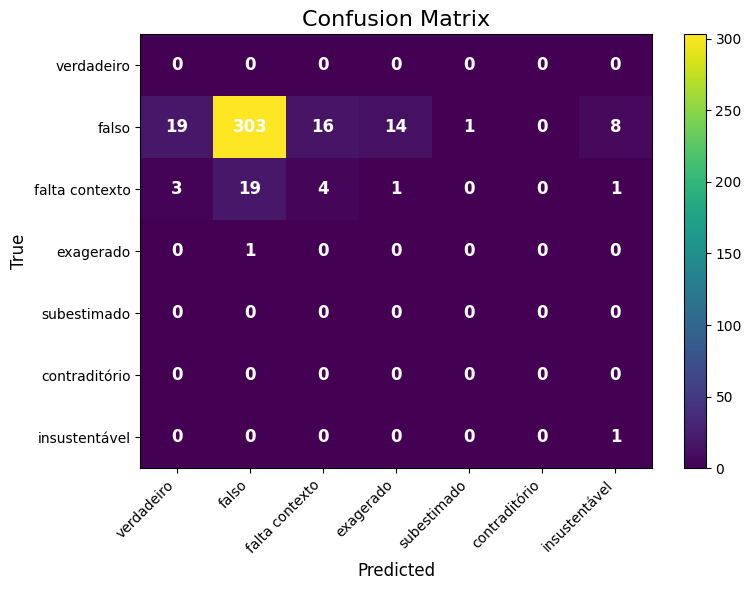

In [ ]:
# O pd.Categorical garante que: Ambos usem a mesma ordem e conjunto de categorias.
gt_cat = pd.Categorical(classificacao_site, categories=todas_as_classificacoes, ordered=True)
pred_cat = pd.Categorical(previsao_modelo, categories=todas_as_classificacoes, ordered=True)

# Converte tudo pra string
gt_cat = [str(x) for x in gt_cat]
pred_cat = [str(x) for x in pred_cat]
todas_as_classificacoes = [str(x) for x in todas_as_classificacoes]



# Filtra os dados válidos (exclui previsões "erro")
dados_validos = [
    (g, p)
    for g, p in zip(gt_cat, pred_cat)
    if p != "erro"
]

# Evita erro se todos forem "erro"
if dados_validos:
    gt_cat_filtrado, pred_cat_filtrado = zip(*dados_validos)

    # Remove "erro" da lista de categorias
    categorias_sem_erro = [c for c in todas_as_classificacoes if c != "erro"]

    # Construção da matriz de confusão (linhas=ground truth, colunas=predicted)
    cm = confusion_matrix(gt_cat, pred_cat, labels=todas_as_classificacoes)

    # Transforma a matriz em DataFrame do pandas para ficar mais legível
    cm_df = pd.DataFrame(cm, index=todas_as_classificacoes, columns=todas_as_classificacoes)

# Cria um heatmap da matriz de confusão:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, aspect='auto')
ax.set_xticks(np.arange(len(todas_as_classificacoes)))
ax.set_yticks(np.arange(len(todas_as_classificacoes)))
ax.set_xticklabels(todas_as_classificacoes, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(todas_as_classificacoes, fontsize=10)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("True", fontsize=12)
ax.set_title("Confusion Matrix", fontsize=16)

for i in range(len(todas_as_classificacoes)):
    for j in range(len(todas_as_classificacoes)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=12, fontweight='bold')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Formas de visualização diferentes/mais info

In [ ]:
# adiciona totais
# support_true → quantos exemplos verdadeiros existem por classe (quantas notícias realmente eram “falsas”, por exemplo).
# predicted_total → quantas vezes o modelo previu cada classe.
cm_df_with_totals = cm_df.copy()
cm_df_with_totals["support_true"] = cm_df_with_totals.sum(axis=1)
cm_df_with_totals.loc["predicted_total"] = list(cm_df_with_totals.sum(axis=0))

# Display 1: tem a saida igual à imagem da matriz
print("Confusion matrix (counts):")
display(cm_df)

# Display 2: faz a soma das saídas no fim para comparação
print("\nConfusion matrix with totals:")
display(cm_df_with_totals)

In [ ]:
'''
Recall (linha) = “o modelo reconhece bem cada classe?”
Precisão (coluna) = “quando ele prevê algo, costuma estar certo?”
'''
# Linha normalizada (recall):
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm_row = np.divide(cm, row_sums, where=(row_sums!=0))
cm_norm_row_df = pd.DataFrame(np.round(cm_norm_row, 3), index=todas_as_classificacoes, columns=todas_as_classificacoes)
print("\n Linha normalizada (recall_cada linha soma a 1):")
display(cm_norm_row_df)

# Coluna normalizada (precisão):
col_sums = cm.sum(axis=0, keepdims=True)
cm_norm_col = np.divide(cm, col_sums, where=(col_sums!=0))
cm_norm_col_df = pd.DataFrame(np.round(cm_norm_col, 3), index=todas_as_classificacoes, columns=todas_as_classificacoes)
print("\nColuna normalizada (precisão_cada coluna soma a 1):")
display(cm_norm_col_df)

In [ ]:
# Relatório automático (classification_report)
print("\nRelatório de classificação (sklearn):")
print(classification_report(gt_cat, pred_cat, labels=todas_as_classificacoes, zero_division=0))


# O código abaixo pode ser usado para compreender oq o sklearn faz automaticamente acima
# não é necessario fazer essa parte, já que tem o mesmo retorno,
# mas achei legal termos isso para entendermos oq está acontecendo!

# Cálculo manual das métricas da matriz de confusão
tp = np.diag(cm)                 # true positives per class
fp = np.sum(cm, axis=0) - tp     # false positives per class
fn = np.sum(cm, axis=1) - tp     # false negatives per class
support = np.sum(cm, axis=1)     # support (true count) per class

# evitando divisão por zero
precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp+fp)!=0)
recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp+fn)!=0)
f1        = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(tp, dtype=float), where=(precision+recall)!=0)
accuracy_overall = tp.sum() / cm.sum()

metrics_df = pd.DataFrame({
    "support": support,
    "true_positive": tp,
    "false_positive": fp,
    "false_negative": fn,
    "precision": np.round(precision, 4),
    "recall": np.round(recall, 4),
    "f1": np.round(f1, 4)
}, index=todas_as_classificacoes)

print("\nMétricas derivadas da matriz de confusão:")
display(metrics_df)
print(f"\nAcurácia geral: {accuracy_overall:.4f}")

## Exportar para Excell

In [ ]:
# cm_df.to_excel("confusion_matrix_counts.xlsx")
# cm_norm_row_df.to_excel("confusion_matrix_row_normalized.xlsx")